## Air-Quality-in-Durban-Part-3-AutoRegressive-Model-with-TimeSeries-Data-from-MongoDB by Dumisani Maxwell Mukuchura

#### Dataset Source: *https://open.africa/dataset/sensorsafrica-airquality-archive-durban*

##### Contact: dumisanimukuchura@gmail.com | LinkedIn: https://www.linkedin.com/in/dumisani-maxwell-mukuchura-4859b7170/

##### This Project is part of a multi-part series focused on analyzing and forecasting air quality in Durban using various statistical and machine learning models. In Part 3, we delve into time series analysis and prediction by implementing an AutoRegressive (AR) model on air quality data sourced from MongoDB. Building on the previous parts, where we explored data preprocessing and Linear Regression models, this part will enhance our prediction capabilities by capturing the temporal dependencies in the data.

Kindly note this was done from a Local machine on Windows with a locally hosted database using Mongo DB, Mongo DB Compass and MongoDB Shell i.e a NoSQL database.  

### Context and Goals of this Project

- Def: AutoRegressive (AR) models are a type of statistical model used for analyzing and forecasting time series data. They are based on the idea that the current value of a time series can be explained by its own previous values, making them particularly useful for time-dependent data.
- Applications of AutoRegressive Models:
  1. Economics and Finance: Used for forecasting stock prices, interest rates, and economic indicators.
  2. Weather Forecasting: Analyzing temperature and precipitation patterns.
  3. Signal Processing: Modeling and predicting audio and speech signals.
  4. Engineering: Analyzing and predicting system behaviour over time.
- Goals:
  1. Data Retrieval: Extract historical air quality data for Durban from a MongoDB database.
  2. Data Preprocessing: Clean and preprocess the data, ensuring it is suitable for time series analysis.
  3. Exploratory Data Analysis (EDA): Visualize the air quality data to identify trends,patterns, and anomalies.
  4. AutoRegressive Model Implementation: Implement an AutoRegressive (AR) model to forecast air quality, leveraging the temporal dependencies in the time series data.
  5. Model Evaluation: Evaluate the performance of the AR model using appropriate metrics and compare it with the Linear Regression model implemented in Part 2.
  6. Visualization: Visualize the results of the AR model predictions and compare them with the actual air quality data.

### Import Libraries and Dependancies

In [2]:
#Import Libraries and Dependencies

import pandas as pd
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt

from pymongo import MongoClient
import pytz #to manipulate python timezones

from sklearn.metrics import mean_absolute_error
from sklearn.utils
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg

## 1. Prepare Data

### 1.1. Connect DataBase/ Import

In [3]:
#Connect Database 
client = MongoClient(host = "localhost", port = 27017) #Instantiate the Client
db = client["air_quality"]  #Connect to air-quality database
durban = db["durban"] #Connect to the Durban collection

In [4]:
#Read into a DataFrame using the Wrangle function 

def wrangle(collection):
    results = collection.find(
        {"value_type": "P2"},
        projection = {"value": 1, "timestamp":1, "_id":0}
    )
    #Read Data into DataFrame
    df = pd.DataFrame(list(results)).set_index("timestamp")

    #Rename Value Column to P2 column 
    df = df.rename(columns = {"value":"P2"})

    #Localize the Timezone 
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Johannesburg")

    #Resample to 1H and create a series 
    y = df["P2"].resample("1h").mean().ffill()
    
    return y 

In [5]:
#Get the Data and Preview it.
y = wrangle(durban)
y.head()

timestamp
2017-11-24 16:00:00+02:00     5.000
2017-11-24 17:00:00+02:00     5.000
2017-11-24 18:00:00+02:00     5.000
2017-11-24 19:00:00+02:00    12.494
2017-11-24 20:00:00+02:00     7.830
Freq: h, Name: P2, dtype: float64

### 1.2. Explore 

#### 1.2.1. Auto Corelation Function ACF Plot 

- looks into how the time series data correlates to itself, it becomes a function looking int the current and its lags

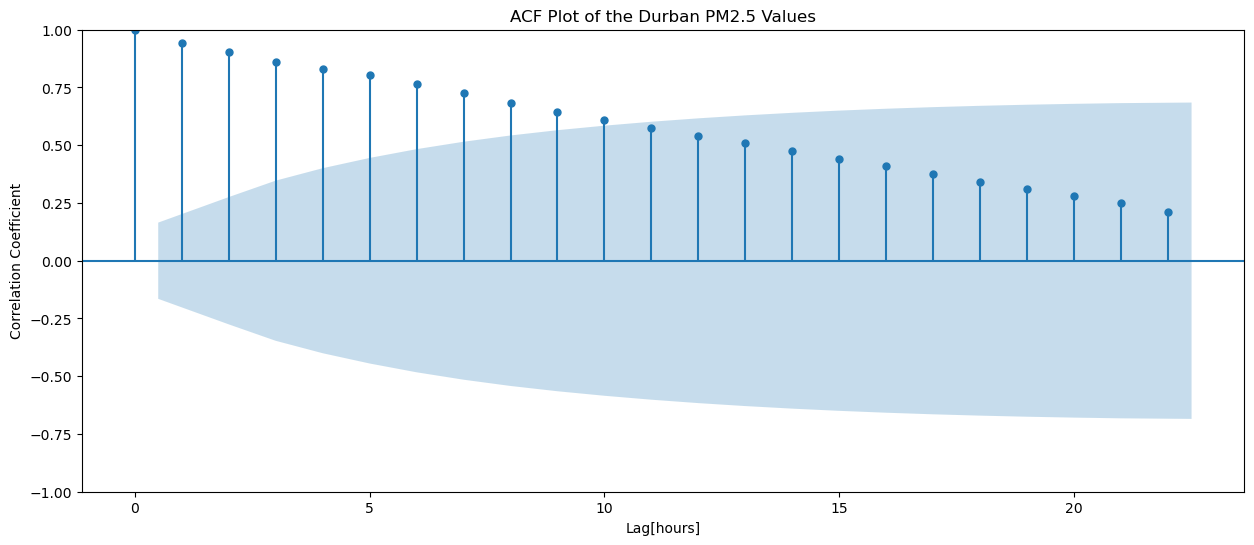

In [6]:
fig, ax = plt.subplots(figsize = (15, 6))
plot_acf(y, ax = ax)
plt.xlabel("Lag[hours]")
plt.ylabel("Correlation Coefficient")
plt.title("ACF Plot of the Durban PM2.5 Values");

- The Correlation in the blue band, the Confidence interval are are not significantly different from zero, suggesting that the observed correlation at those lags could be due to random chance.

#### 1.2.2. Partial Auto Corelation Function, PACF Plot 

- looks into how the time series data correlates to itself, it becomes a function looking int the current and its lags but without the echo or spillage.

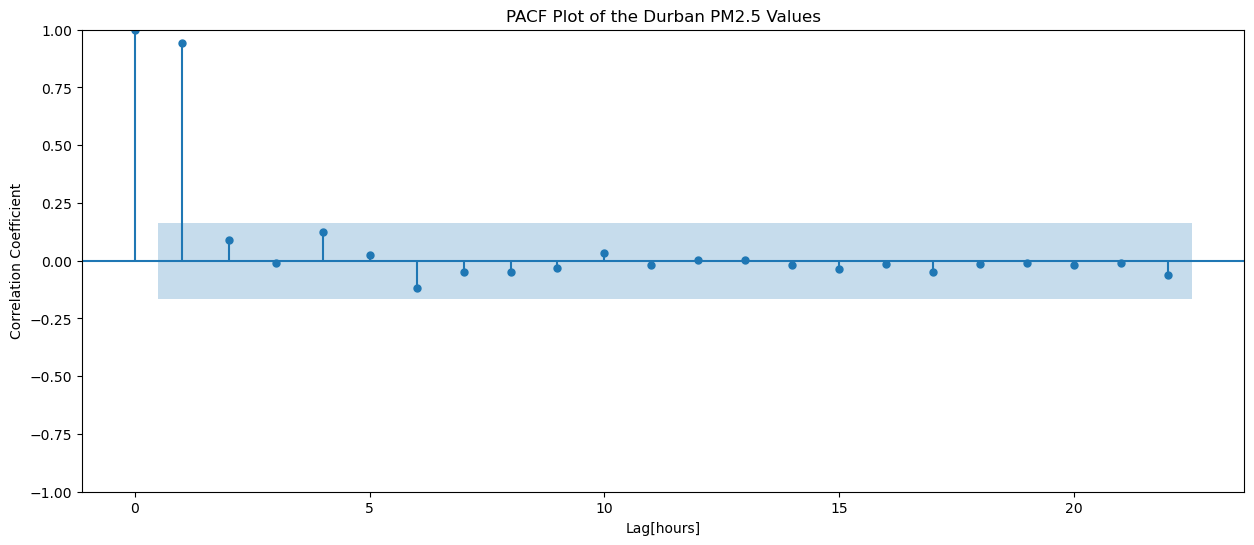

In [7]:
fig, ax = plt.subplots(figsize = (15, 6))
plot_pacf(y, ax = ax)
plt.xlabel("Lag[hours]")
plt.ylabel("Correlation Coefficient")
plt.title("PACF Plot of the Durban PM2.5 Values");

- Utilizing the PACF plot to determine how many lags we should go into the past. In this instance it is just 1 lag.

### 1.3. Split Data 

- We have a series and in this instance we are to perform a y_train and y_test split since we do not have X - feature we just associate the y with the timestamp

In [8]:
#Splitting Data 
cutoff_test = int(len(y) * 0.8)

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

len(y_train) + len(y_test) == len(y)

True

## 2. Build Model

- We have a series and not a DataFrame this time around and as we build this AutoReg Model with 1 lag we specify it in the definition of the model.

### 2.1. Baseline Model

In [12]:
#Baseline Model that assumes the mean as the predicted value

y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean PM2.5 Value:", round(y_mean, 2))
print("Mean Absolute Error:", round(baseline_mae, 2))

Mean PM2.5 Value: 12.07
Mean Absolute Error: 5.58


### 2.2. Iterate Model with AutoReg Model

In [13]:
#Instantiate and Fit the model with AutoReg with lag = 1
model = AutoReg(y_train, lags=1).fit()

- We need to check the mean_absolute_error for training data but we do not have the predictions so we use the train data on the model and predict but in doing so we had introduced a lag and NaN values may appear in the prediction due to there initially being less values that what the lag requires thus we have to specify to drop them and also consider only predictions after the lagging stream has been satisfied.
- E.g. 
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train[26:], y_pred)
print("Training MAE:", training_mae)
- The purpose of dropna() is to remove any NaN (Not a Number) values from the predictions. When using an AutoReg model with a lag, the initial predictions may contain NaNs due to the insufficient number of lagged values at the beginning of the dataset.
- For example, with a lag of 26, the first 26 predictions will be NaN since there aren't enough past values to make predictions. Using .dropna() ensures that these NaN values are removed, leaving only valid predictions.
- y_train[26:]: The actual training data values starting from the 27th value (index 26) onward. This is done because the first 26 values of y_train correspond to the NaN predictions that were removed.

In [17]:
#Mean Absolute Error on Training Data 
y_pred_training = model.predict().dropna()
training_mae = mean_absolute_error(y_train[1:], y_pred_training)
print("Training MAE:", round(training_mae, 2))

Training MAE: 0.66


In [18]:
#Calculate the Residuals
y_train_resid = model.resid
y_train_resid.head()

timestamp
2017-11-24 17:00:00+02:00   -0.420329
2017-11-24 18:00:00+02:00   -0.420329
2017-11-24 19:00:00+02:00    7.073671
2017-11-24 20:00:00+02:00   -4.681422
2017-11-24 21:00:00+02:00   -0.498177
Freq: h, dtype: float64

- Residuals are the differences between the the true value and the predicted value.

### 2.3. Residuals Time Series Plot

<Axes: xlabel='timestamp', ylabel='Residual Value'>

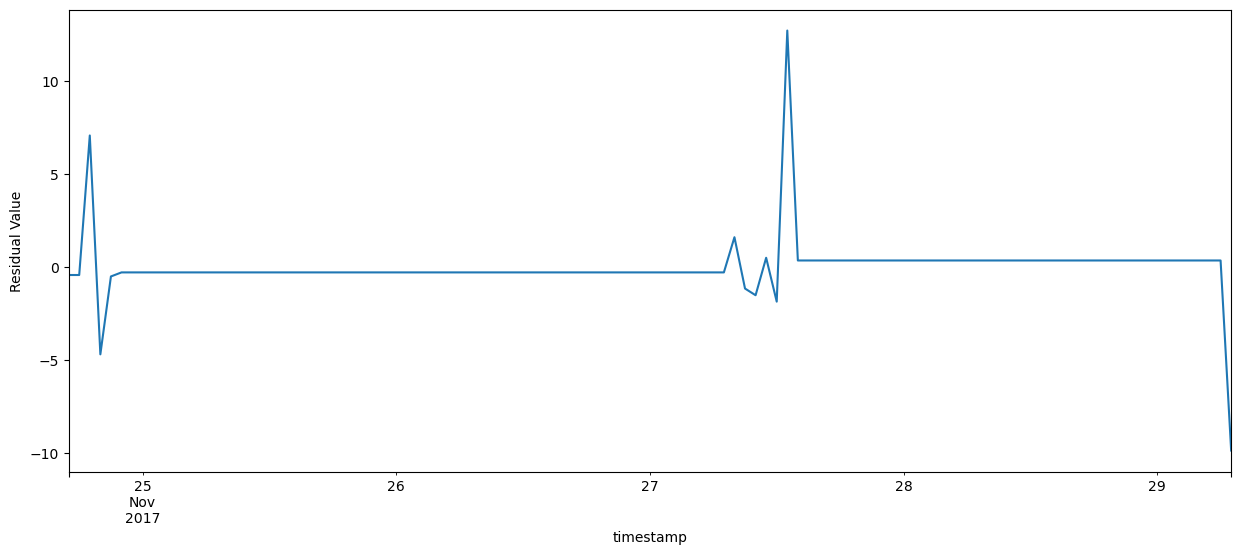

In [19]:
#Residuals Time Series Plot: Upwards means underestimated, Downwards means Overestimated

fig, ax = plt.subplots(figsize = (15,6))
y_train_resid.plot(ax = ax, ylabel = "Residual Value")

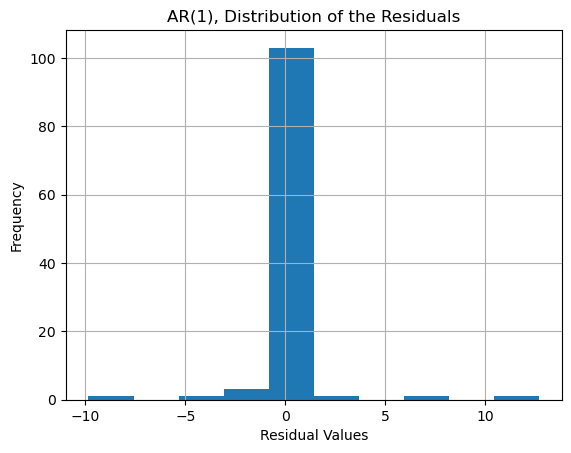

In [23]:
#Plot a Histogram of the Residuals 

#plt.hist(y_train_resid)
y_train_resid.hist();
plt.xlabel("Residual Values")
plt.ylabel("Frequency")
plt.title("AR(1), Distribution of the Residuals");

- The residuals should take form of a normal distribution curve. WHY? Predictive Accuracy: When the residuals are normally distributed, it indicates that the model has accounted for most of the patterns in the data and the remaining errors are just random noise. This gives a good indication that the model is performing well.

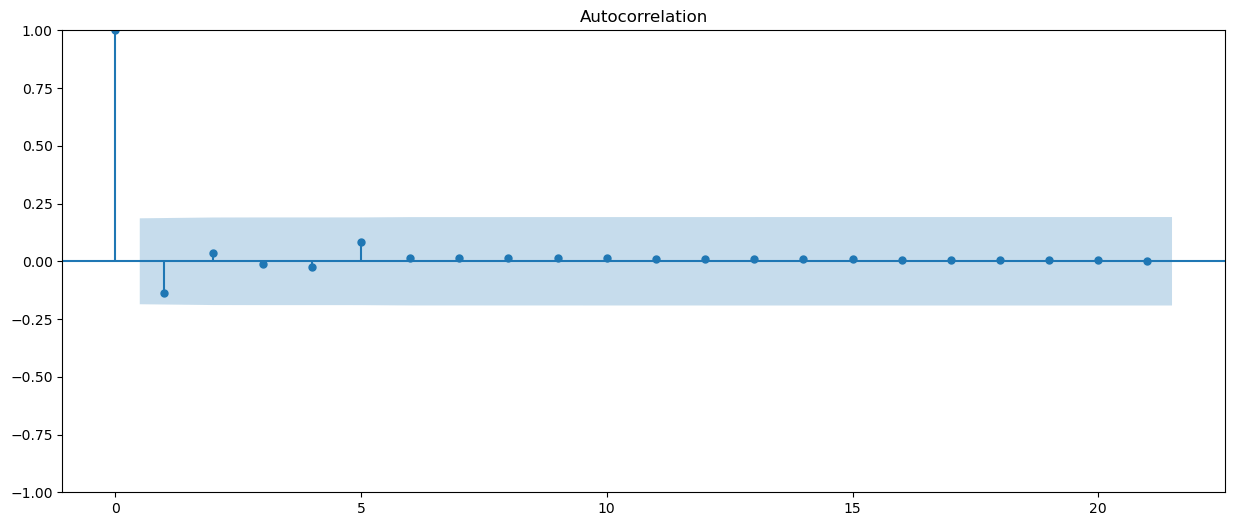

In [26]:
#ACF Plot for the Residuals
fig, ax = plt.subplots(figsize =(15,6))
plot_acf(y_train_resid, ax=ax);
plt.xlabel("lag[Hours]")
plt.ylabel("Correlation ")